In [ ]:
import torch
import logging
import statistics
import numpy as np
import src.clip as clip
from torchinfo import summary
import matplotlib.pyplot as plt
import torchvision.transforms as T
from accelerate import Accelerator
from yacs.config import CfgNode as CN
from main import get_config, init_accelerator, set_seed, FFPP
from src.models import Detector
logging.basicConfig(level="DEBUG")


class Obj:
    pass


c = FFPP.get_default_config()
# c.augmentation = "normal+frame"
# c.augmentation = "none"
c.random_speed = 0
c.pair = 1
c.compressions = ["c23"]
# c.contrast = 1
# c.contrast_pair = 1
c.types = ["REAL", "NT", "DF", "FS", "F2F"]
# c.types = ["NT", "DF", "FS", "F2F"]
# c.types = ["REAL", "NT"]
# c.types = ["REAL"]


mc = Detector.get_default_config()
mc.out_dim = [2]
mc.adapter = CN()
mc.adapter.frozen = 0
mc.adapter.struct = CN()
# mc.adapter.struct.type = "legacy-768-x-768"
mc.adapter.struct.type = "768-x-768-nln"
mc.adapter.struct.x = 256
mc.adapter.type = "normal"

accelerator = Accelerator(mixed_precision='no')
model = Detector(mc, 20, accelerator).to(accelerator.device).eval()
model.to("cuda")
# encoder = clip.load("ViT-B/16")[0].visual.float()
encoder = model.encoder
# adapter = model.adapter
# adapter.load_state_dict(
#     {
#         k[8:]: v for k, v in
#         torch.load(
#             # "/home/od/Desktop/repos/dfd-clip/logs/comp-inv/comp-inv/mode1+256+resi+1e-2/last_weights.pt",
#             "/home/od/Desktop/repos/dfd-clip/logs/test/0520T1305/best_weights.pt",
#             map_location="cpu"
#         ).items()
#         if "adapter" in k
#     }
# )


transform = model.transform
n_px = 224
frames = 20
seconds = 1

x = FFPP(c.clone(), frames, seconds, transform, accelerator, split="train")
_x = FFPP(
    c.clone(),
    frames,
    seconds,
    T.Compose([
              T.Resize(n_px, interpolation=T.InterpolationMode.BICUBIC),
              T.CenterCrop(n_px),
              T.ConvertImageDtype(torch.float32)
              ]),
    accelerator,
    split="train"
)

In [ ]:
print(c)
print(len(x))

In [ ]:
vid_idx = next(i for i, x in enumerate(x.video_list) if x[2] == "193_030")
idx = next(i for i in range(len(x)) if x.video_info(i)[0] == vid_idx)

In [ ]:
import random
# idx = random.randint(0, len(x))
# idx = 1825
# idx = 1470
# idx = 27392
data = x[idx + 1]
_data = _x[idx + 1]

# data = [{
#     k: data[0][i]["c23"]
#     for i, k in enumerate(["raw", "c23"])
# }]
# _data = [{
#     k: _data[0][i]["c23"]
#     for i, k in enumerate(["raw", "c23"])
# }]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
fig_scale = 3
plt.figure(figsize=(frames * fig_scale, 2 * fig_scale))
for i, q in enumerate(["raw", "c23"]):
    d = _data[0][q].numpy().transpose((0, 2, 3, 1))
    for j, f in enumerate(d):
        plt.subplot(2, frames, i * frames + j + 1)
        plt.imshow(f)
        plt.gca().set_yticks([i for i in range(n_px) if i % 16 == 0])
        plt.gca().set_xticks([i for i in range(n_px) if i % 16 == 0])
        plt.gca().xaxis.set_tick_params(labelbottom=False)
        plt.gca().yaxis.set_tick_params(labelleft=False)
        plt.grid(True, alpha=0.5)

In [ ]:
features = {}
# nfeatures = {}
with torch.no_grad():
    for k, imgs in data[0].items():
        # get key and value from each CLIP ViT layer
        kvs = encoder(imgs.to("cuda"), with_out=True, with_q=True)
        # discard original CLS token and restore temporal dimension
        kvs = [{k: v[:, 1:] for k, v in kv.items()} for kv in kvs]
        kvs = [{k: v.view(*v.shape[:2], 768).to("cpu") for k, v in kv.items()} for kv in kvs]
        features[k] = kvs
torch.cuda.empty_cache()

In [ ]:
# b = torch.max(
#     torch.abs(
#         (features["c23"][0]["k"] - torch.mean(features["c23"][0]["k"], dim=0)) /
#         torch.var(features["c23"][0]["k"], dim=0)
#     ).mean(dim=-1),
#     dim=0
# )[0]
# features["raw"][0]["k"].shape, features["raw"][0]["k"][0, 14 * 4 + 4].shape
# torch.nn.functional.cosine_similarity(
#     features["raw"][0]["k"],
#     features["raw"][0]["k"][0, 14 * 4 + 4],
#     dim=-1
# ).mean(dim=0)

In [ ]:
# # This scenario shows the distribution of each subject(k,v,out)
# # throughout the temporal dimension of each ViT layer
# methods = {}
# for m in ["raw", "c23"]:
#     l = {
#         "k": [],
#         "v": [],
#         "out": []
#     }
#     for l2 in range(12):
#         for subject in ["k", "v", "out"]:
#             l[subject].append(
#                 torch.var(features[m][l2][subject], dim=0).mean(dim=-1).view((14, 14))
#                 # torch.max(
#                 #     torch.abs(
#                 #         (features[m][l2][subject] - torch.mean(features[m][l2][subject], dim=0)) /
#                 #         torch.sqrt(torch.var(features[m][l2][subject], dim=0))
#                 #     ).mean(dim=-1),
#                 #     dim=0
#                 # )[0].view(14, 14)
#             )
#     methods[m] = l


# for name, l in methods.items():
#     plt.figure(figsize=(36, 9), layout="constrained")
#     plt.suptitle(f'{name}', fontsize=12)
#     for j, s in enumerate(["k", "v", "out"]):
#         for i, v in enumerate(l[s]):
#             plt.subplot(3, 12, j * 12 + i + 1)
#             im = plt.imshow(v)

#             # Show all ticks and label them with the respective list entries
#             plt.gca().set_xticks(np.arange(14))
#             plt.gca().set_yticks(np.arange(14))

#     plt.tight_layout()
#     plt.show()

In [ ]:
# This scenario shows the similarity given a patch location of the first frame and all video patches.
# The result is an temporally averaged value for each patch location.
methods = {}
subjects = ['q', 'k', 'v', 'out']
# qualities = ["raw", "c23"]
# subjects = ['k']
qualities = ["c23"]
patch_loc = 14 * 1 + 7
for m in qualities:
    l = {
        s: []
        for s in subjects
    }
    for l2 in range(12):
        for subject in subjects:
            l[subject].append(
                (torch.nn.functional.cosine_similarity(
                    features[m][l2][subject],
                    features[m][l2][subject][0, patch_loc],
                    dim=-1
                ) / (768 ** 0.5)).softmax(dim=-1).view((-1, 14, 14)).permute(1, 0, 2).flatten(1, 2)
            )
    methods[m] = l

# This section calculates the difference of the raw and c23 attention scores.
# methods["diff"] = {}
# for s in subjects:
#     methods["diff"][s] = []
#     for l2 in range(12):
#         methods["diff"][s].append(torch.abs(methods["raw"][s][l2] - methods["c23"][s][l2]))

for name, l in methods.items():
    for _, s in enumerate(subjects):
        plt.figure(figsize=(60, 36), layout="constrained")
        plt.suptitle(f'{name}-{s}', fontsize=12)
        for j in range(12):
            plt.subplot(12, 1, j + 1)

            im = plt.imshow(l[s][j])
    plt.show()

In [ ]:
# This is a multi-sample version of the methods above which compares the specified patch location in the first frame
# and calculates the attentional score with the remaining patches throughout the video clip.

# import random
# from tqdm import tqdm

# subjects = ['q', 'k', 'v', 'out']
# # qualities = ["raw", "c23"]
# # subjects = ['k']
# qualities = ["c23"]


# methods = {
#     q: {
#         s: [torch.zeros((14, frames * 14)) for _ in range(12)]
#         for s in subjects
#     } for q in qualities
# }

# for i in tqdm(range(20)):
#     ########## random select index ############
#     idx = random.randint(0, len(x))
#     data = x[idx]

#     ######### extract video features ###########
#     features = {}
#     with torch.no_grad():
#         for k, imgs in data[0].items():
#             # get key and value from each CLIP ViT layer
#             kvs = encoder(imgs.to("cuda"), with_out=True, with_q=True)
#             # discard original CLS token and restore temporal dimension
#             kvs = [{k: v[:, 1:] for k, v in kv.items()} for kv in kvs]
#             kvs = [{k: v.view(*v.shape[:2], 768).to("cpu") for k, v in kv.items()} for kv in kvs]
#             features[k] = kvs
#     torch.cuda.empty_cache()

#     ######### extract video features ###########
#     for m in qualities:
#         for l2 in range(12):
#             for subject in subjects:nose
#                 methods[m][subject][l2] += (torch.nn.functional.cosine_similarity(
#                     features[m][l2][subject],
#                     features[m][l2][subject][0, 14 * 2 + 5],
#                     dim=-1
#                 ) / (768**0.5)).softmax(dim=-1).view((-1, 14, 14)).permute(1, 0, 2).flatten(1, 2) / 100


# for name, l in methods.items():
#     for _, s in enumerate(subjects):
#         plt.figure(figsize=(60, 36), layout="constrained")
#         plt.suptitle(f'{name}-{s}', fontsize=12)
#         for j in range(12):
#             plt.subplot(12, 1, j + 1)

#             im = plt.imshow(l[s][j])
#     plt.show()

In [ ]:
# This section collects patches of specific locations and calculates the mean of patches as the desire semantic meaning.

import random
from tqdm import tqdm

semantic_locations = {
    "eyes": [
        [4, 3], [4, 4], [4, 9], [4, 10]
    ],
    "nose": [
        [7, 6], [6, 6], [5, 6]
    ],
    "lips": [
        [10, 5], [10, 6], [10, 7]
    ],
    "eyebrows": [
        [2, 3], [2, 4], [3, 4], [3, 5], [3, 8], [3, 9], [2, 9], [2, 10]
    ],
    "skin": [
        [0, 6], [0, 7], [1, 6], [1, 7],
        [7, 3], [7, 4], [7, 10], [7, 11],
        [11, 6], [11, 7], [12, 6], [12, 7]
    ]
}

semantic_locations = {k: [_v[0] * 14 + _v[1] for _v in v] for k, v in semantic_locations.items()}

subjects = ['q', 'k', 'v', 'out']
# qualities = ["raw", "c23"]
# subjects = ['k']
qualities = ["c23"]

semantic_patches = {
    s: {
        k: [[] for _ in range(12)]
        for k in semantic_locations.keys()
    }
    for s in subjects
}

methods = {
    q: {
        s: [torch.zeros((14, frames * 14)) for _ in range(12)]
        for s in subjects
    } for q in qualities
}

for i in range(100):
    ########## random select index ############
    idx = random.randint(0, len(x))
    data = x[idx]

    ######### extract video features ###########
    features = {}
    with torch.no_grad():
        for k, imgs in data[0].items():
            # get key and value from each CLIP ViT layer
            kvs = encoder(imgs[0].unsqueeze(0).to("cuda"), with_out=True, with_q=True)
            # discard original CLS token and restore temporal dimension
            kvs = [{k: v[:, 1:] for k, v in kv.items()} for kv in kvs]
            kvs = [{k: v.view(*v.shape[:2], 768).to("cpu") for k, v in kv.items()} for kv in kvs]
            features[k] = kvs

    torch.cuda.empty_cache()

    ######### extract video features ###########
    for m in qualities:
        for l2 in range(12):
            for subject in subjects:
                for part, indices in semantic_locations.items():
                    semantic_patches[subject][part][l2].extend(features[m][l2][subject][0, indices].tolist())

semantic_patches = {
    s: {
        k: [
            torch.tensor(semantic_patches[s][k][i]).mean(dim=0)
            for i in range(12)
        ]
        for k in semantic_locations.keys()
    }
    for s in subjects
}

In [ ]:
features = {}
with torch.no_grad():
    for _ in range(300):
        data = x[random.randrange(0, len(x))]
    for k, imgs in data[0].items():
        # get key and value from each CLIP ViT layer
        kvs = encoder(imgs.to("cuda"), with_out=True, with_q=True)
        # discard original CLS token and restore temporal dimension
        kvs = [{k: v[:, 1:] for k, v in kv.items()} for kv in kvs]
        kvs = [{k: v.view(*v.shape[:2], 768).to("cpu") for k, v in kv.items()} for kv in kvs]
        if not k in features:
            features[k] = []
        features[k].append(kvs)
torch.cuda.empty_cache()

In [52]:
# This section shows the similarity score given a semantic patch embedding from the collected patches of a previous phase.
methods = {}
# subjects = ['q', 'k', 'v', 'out']
subjects = ['k']
# qualities = ["raw", "c23"]
# subjects = ['k']
qualities = ["c23"]
l = {
    s: [0 for _ in range(12)]
    for s in subjects
}
for feature in features["c23"]:
    for l2 in range(12):
        for subject in subjects:
            l[subject][l2] += (
                (torch.nn.functional.cosine_similarity(
                    feature[l2][subject],
                    semantic_patches["q"]["lips"][l2],
                    dim=-1
                ) / (768 ** 0.5)).softmax(dim=-1).view((-1, 14, 14))
            ) / len(features["c23"])

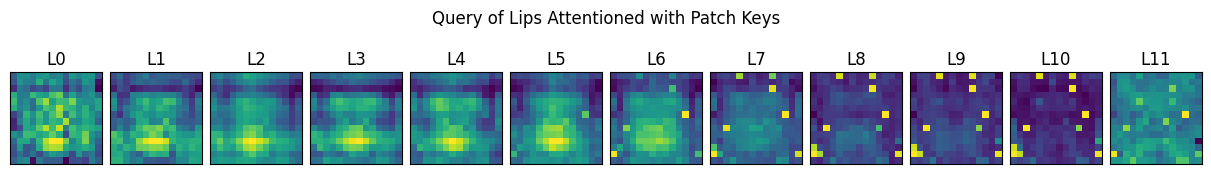

In [54]:
for _, s in enumerate(subjects):
    plt.figure(figsize=(12, 2), layout="constrained")
    plt.suptitle(f'Query of Lips Attentioned with Patch Keys', fontsize=12)
    for j in range(12):
        plt.subplot(1, 12, j + 1)
        im = plt.imshow(l[s][j][0])
        plt.title(f"L{j}")
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
plt.show()

In [ ]:
import pickle
with open("misc/semantic_patches.pickle", "wb") as f:
    pickle.dump(semantic_patches, f)